In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.4.6 numpy==1.18.5 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.9.1


In [3]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results


In [4]:
adata = sc.read_h5ad(
    'BCR_Healthy.h5ad')  # the directory with the `.mtx` file


In [5]:
adata.var_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


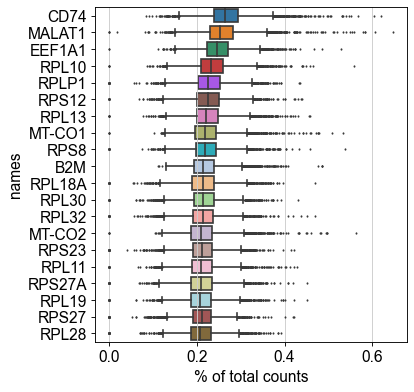

In [6]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 16218 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

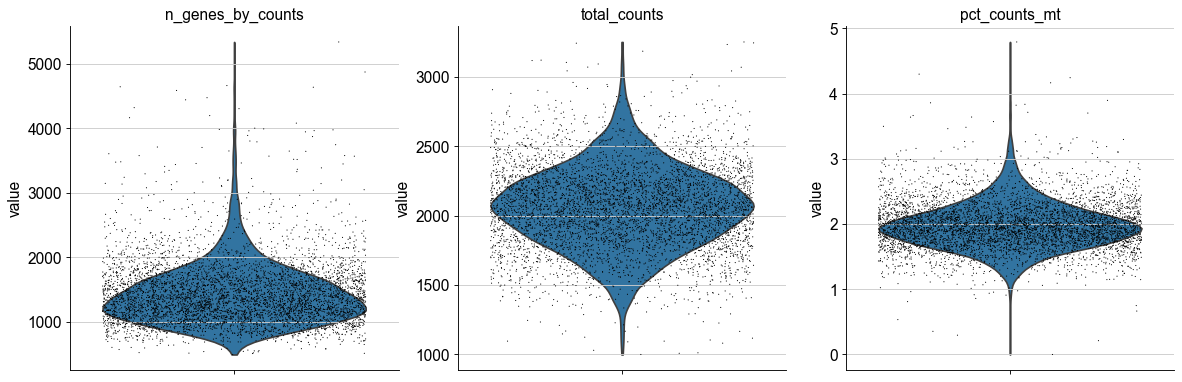

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

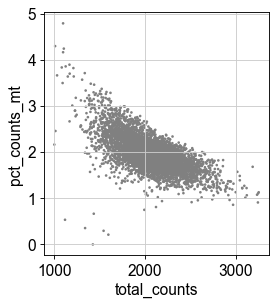

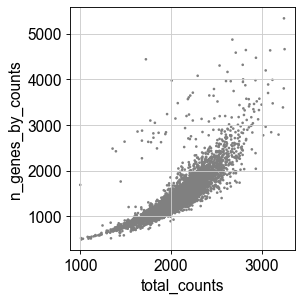

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [11]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [12]:
adata.X = scipy.sparse.csr_matrix(adata.X)

In [13]:
sc.pp.highly_variable_genes(adata)


extracting highly variable genes
/Users/sophieliu/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
    finished (0:00:00)
Trying to set attribute `.uns` of view, copying.
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


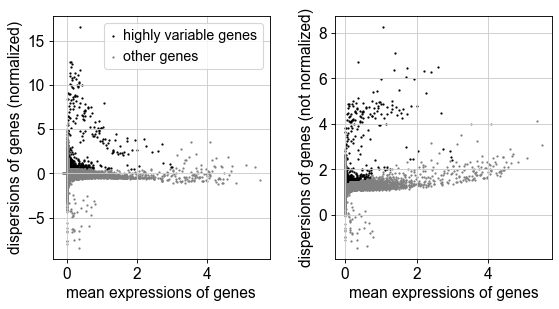

In [14]:
sc.pl.highly_variable_genes(adata)


In [15]:
adata.raw = adata


In [16]:
adata = adata[:, adata.var.highly_variable]


In [17]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [18]:
sc.pp.scale(adata, max_value=10)


In [19]:
sc.tl.pca(adata, svd_solver='arpack')


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


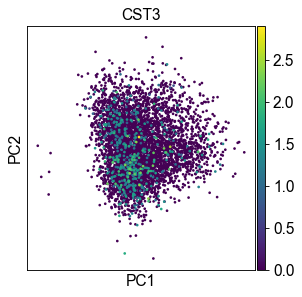

In [20]:
sc.pl.pca(adata, color='CST3')


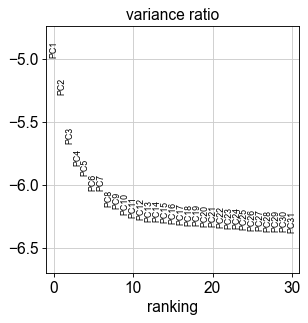

In [21]:
sc.pl.pca_variance_ratio(adata, log=True)
#---- Stephanie -----

In [22]:
adata.write(results_file)


In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [24]:
sc.tl.umap(adata)


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [25]:
sc.tl.leiden(adata)
#i had to do pip install leiden alg 

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


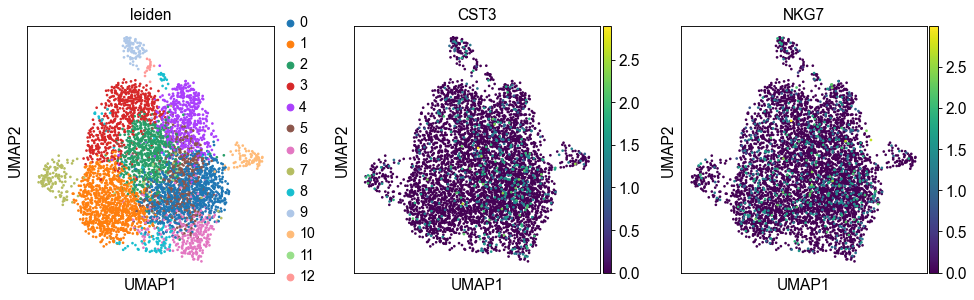

In [26]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])
adata.write(results_file)


In [27]:
# # ----- Alyssa 
# sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)


In [28]:
sc.settings.verbosity = 2  # reduce the verbosity
# --- Aj

ranking genes
/Users/sophieliu/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
    finished (0:00:07)


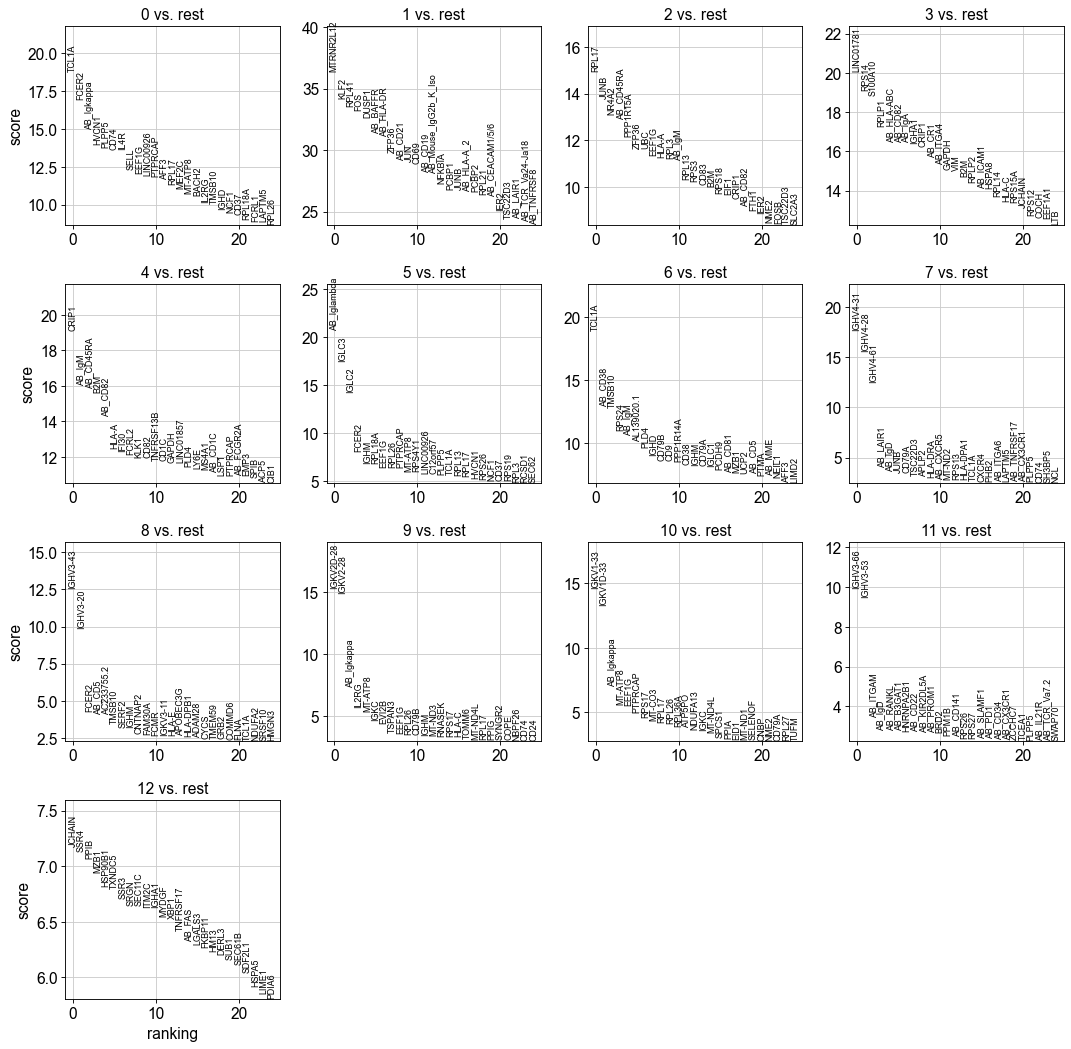

In [29]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [30]:
adata.write(results_file)

In [31]:
# sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [32]:
marker_genes = ['IGHA1', 'JCHAIN', 'IGHV3-43', 'IGKV2D-28', 'IGKV2-28', 'IGKV1-33', 'IGLC3']

In [33]:
adata = sc.read(results_file)


In [34]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,TCL1A,MTRNR2L12,RPL17,LINC01781,CRIP1,AB_Iglambda,TCL1A,IGHV4-31,IGHV3-43,IGKV2D-28,IGKV1-33,IGHV3-66,JCHAIN
1,FCER2,KLF2,JUNB,RPS14,AB_IgM,IGLC3,AB_CD38,IGHV4-28,IGHV3-20,IGKV2-28,IGKV1D-33,IGHV3-53,SSR4
2,AB_Igkappa,RPL41,NR4A2,S100A10,AB_CD45RA,IGLC2,TMSB10,IGHV4-61,FCER2,AB_Igkappa,AB_Igkappa,AB_ITGAM,PPIB
3,HVCN1,FOS,AB_CD45RA,RPLP1,B2M,FCER2,RPS24,AB_LAIR1,AB_CD5,IL2RG,MT-ATP8,AB_IgD,MZB1
4,PLPP5,DUSP1,PPP1R15A,AB_HLA-ABC,AB_CD82,IGHM,AB_IgM,AB_IgD,AC233755.2,MT-ATP8,EEF1G,AB_RANKL,HSP90B1


In [35]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,...,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p
0,TCL1A,1.368913e-78,MTRNR2L12,9.689584e-290,RPL17,1.913344e-50,LINC01781,1.543802e-89,CRIP1,8.281929e-82,...,IGHV3-43,2.357366e-36,IGKV2D-28,4.871134e-53,IGKV1-33,1.385794e-48,IGHV3-66,2.308186e-23,JCHAIN,6.910963e-13
1,FCER2,1.584398e-64,KLF2,4.660729e-257,JUNB,2.833778e-43,RPS14,2.464192e-81,AB_IgM,9.988017e-58,...,IGHV3-20,4.332335e-23,IGKV2-28,4.655640e-50,IGKV1D-33,1.993265e-40,IGHV3-53,2.369056e-21,SSR4,9.647014e-13
2,AB_Igkappa,1.131731e-50,RPL41,2.739387e-247,NR4A2,2.192964e-39,S100A10,1.557597e-79,AB_CD45RA,1.248601e-56,...,FCER2,1.413369e-05,AB_Igkappa,3.052806e-13,AB_Igkappa,2.063397e-12,AB_ITGAM,6.044155e-04,PPIB,1.548787e-12
3,HVCN1,1.807969e-44,FOS,6.576377e-242,AB_CD45RA,4.432546e-38,RPLP1,4.158930e-67,B2M,3.598776e-55,...,AB_CD5,4.213358e-05,IL2RG,1.483743e-08,MT-ATP8,2.426127e-08,AB_IgD,5.299693e-03,MZB1,3.876426e-12
4,PLPP5,1.968624e-43,DUSP1,3.343208e-234,PPP1R15A,4.077205e-34,AB_HLA-ABC,5.505836e-61,AB_CD82,2.227796e-46,...,AC233755.2,4.530539e-05,MT-ATP8,6.862538e-08,EEF1G,3.608638e-08,AB_RANKL,5.366089e-03,HSP90B1,9.338904e-12


ranking genes
/Users/sophieliu/opt/anaconda3/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
    finished (0:00:02)


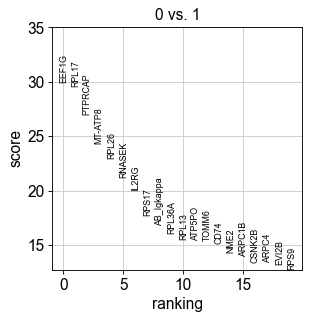

In [36]:
#---- Sophie
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [41]:
marker_genes = ['FOS', 'RPL28', 'KLF2', 'PLD4', 'JUNB', 'DUSP1', 'CD74', 'BTG1', 'PTPRC', 'FCER2',]
marker_genes = ["FOS", "KLF2", "PNRC1", "NFKB1", "JUN", "DUSP1", "FOSB", "GADD45B", "IER2", "ZFP36", 
                "PPP1R15A", "NFKBIA", "CD69", "BTG2",'CD79A', 'CD79B', 'CD19', 'CD40', 'PTPRC', 'LYN',
                'BLNK', 'BTK', 'BLK','FCGR2B', 'CD22', 'CD72', 'SIGLEC10', 'PECAM1', 'PTPN6', 'PTPN11', 'INPP5D']

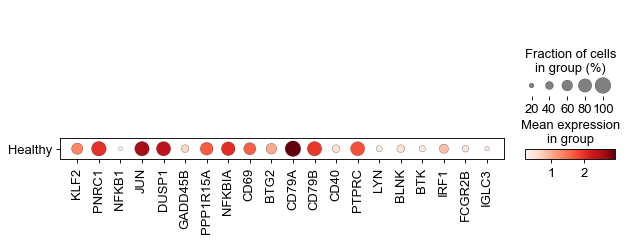

In [45]:
marker_genes = ["KLF2", "PNRC1", "NFKB1", "JUN", "DUSP1", "GADD45B", 
                "PPP1R15A", "NFKBIA", "CD69", "BTG2",'CD79A', 'CD79B', 'CD40', 'PTPRC', 'LYN',
                'BLNK', 'BTK', 'IRF1','FCGR2B', 'IGLC3']
sc.pl.dotplot(adata, marker_genes, groupby='Status_on_day_collection_summary');

In [39]:
print(type(adata))

<class 'anndata._core.anndata.AnnData'>


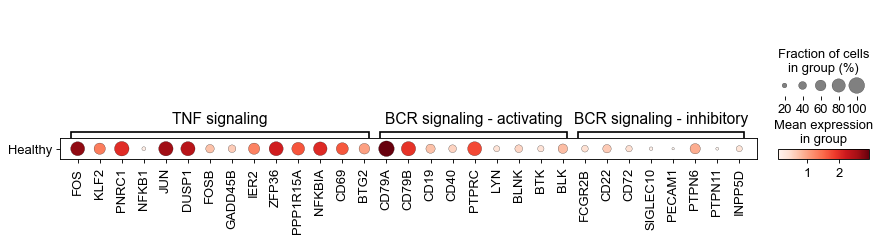

In [46]:
genes = {
    'TNF signaling':["FOS", "KLF2", "PNRC1", "NFKB1", "JUN", "DUSP1", "FOSB", "GADD45B", "IER2", "ZFP36", "PPP1R15A", "NFKBIA", "CD69", "BTG2"],
    'BCR signaling - activating':['CD79A', 'CD79B', 'CD19', 'CD40', 'PTPRC', 'LYN', 'BLNK', 'BTK', 'BLK'],
    'BCR signaling - inhibitory':['FCGR2B', 'CD22', 'CD72', 'SIGLEC10', 'PECAM1', 'PTPN6', 'PTPN11', 'INPP5D']}
sc.pl.dotplot(adata, genes, groupby='Status_on_day_collection_summary', var_group_rotation=0)